In [1]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import rioxarray
import scipy.io as sio
import datetime
import pandas as pd
from scipy.signal import argrelextrema, argrelmax, argrelmin

In [2]:
files = [r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb08_mosaicked.mat',
        r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb10_mosaicked.mat',
        r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb11_mosaicked.mat',
        r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb12_mosaicked.mat'
        ]

Convert to NetCDF

In [3]:
aircraft_data_mat = sio.loadmat(files[0])  

In [4]:
# create dataset
ds = xr.Dataset({
    'STCtemp': xr.DataArray(
                data   = aircraft_data_mat['STCtemp'], # scaled IR temperature data
                dims   = ['y', 'x', 'time'],
                coords = {'x': aircraft_data_mat['Eutm'].squeeze(), # easting coordinates (MGRS-UTM, m
                          'y': aircraft_data_mat['Nutm'].squeeze(), # northing grid coordinates (MGRS-UTM, 
                          'time': aircraft_data_mat['time'].squeeze()}, # time in epoch
                attrs  = {
                    '_FillValue'  : np.nan,
                    'units'       : 'C',
                    'description' : 'Airborne thermal infrared from University of Washington Applied Physics Lab Compact Airborne System for Imaging the Environment instrument.'
                    }
                ),
    'zDEM': xr.DataArray(
                data   = aircraft_data_mat['zDEM'], # elevation (meters)
                dims   = ['y', 'x'],
                coords = {'x': aircraft_data_mat['Eutm'].squeeze(),
                          'y': aircraft_data_mat['Nutm'].squeeze()},
                attrs  = {
                    '_FillValue'  : np.nan,
                    'units'       : 'm',
                    'description' : 'DEM from SRTM 1 arc-second product merged, and clipped around Grand Mesa https://doi.org/10.5066/F7PR7TFT'
                    }
            )
},
        attrs = {'example_attr': 'this is a global attribute'}
    )

In [5]:
ds.rio.set_spatial_dims('y', 'x', inplace=True)
ds.rio.write_crs("epsg:32613", inplace=True) # UTM Zone 13N

<xarray.Dataset>
Dimensions:      (time: 17, x: 4171, y: 3581)
Coordinates:
  * x            (x) int32 218150 218155 218160 218165 ... 238990 238995 239000
  * y            (y) int32 4314100 4314105 4314110 ... 4331990 4331995 4332000
  * time         (time) float64 1.581e+09 1.581e+09 ... 1.581e+09 1.581e+09
    spatial_ref  int32 0
Data variables:
    STCtemp      (y, x, time) float32 nan nan nan nan nan ... nan nan nan nan
    zDEM         (y, x) float32 1935.4832 1937.1373 ... 2911.9229 2912.754
Attributes:
    example_attr:  this is a global attribute
    grid_mapping:  spatial_ref

Convert from matlab time to python datetime

In [6]:
M = ds.time.values
base_date = datetime.datetime(1970,1,1,0,0,0)
return_matrix = []
for time in M:
    return_matrix.append(base_date + datetime.timedelta(seconds=time))
ds['time'] = return_matrix

---

In [7]:
def get_hist_trough(data):
    # first, find peaks
    x_peaks, y_peaks, _, _ = get_hist_peaks(data)
    
    # only look at data between the two peaks
    data = data[(data > x_peaks[0]) & (data < x_peaks[1])]
    
    # data histogram
    n_histogram, _ = np.histogram(data, bins=100, density=True)
    
    # make our own data bins of length n
    x = np.linspace(np.min(data), np.max(data), num=len(n_histogram))
    
    # find minimum n_troughs
    trough_y_values = np.sort(n_histogram[argrelmin(n_histogram, order=1)])[0]
    # find corresponding x values to the n_troughs
    trough_x_values = x[np.where(np.isin(n_histogram,trough_y_values))]
    
    # demo plot
    #plt.bar(x, n_histogram)
    #plt.plot(trough_x_values, trough_y_values,'or')
    
    x_hist = x
    y_hist = n_histogram
    
    return trough_x_values, trough_y_values, x_hist, y_hist

In [57]:
def get_hist_peaks(data,n_peaks=2):
    # remove nans from data
    data = data[~np.isnan(data)]
    
    # data histogram
    n_histogram, _ = np.histogram(data, bins=100, density=True)
    
    # make our own data bins of length n
    x = np.linspace(np.min(data), np.max(data), num=len(n_histogram))
    
    # find maximum n_peaks
    peak_y_values = np.sort(n_histogram[argrelmax(n_histogram, order=2)])[-n_peaks:][::-1]
    # find corresponding x values to the n_peaks
    peak_x_values = x[np.where(np.isin(n_histogram,peak_y_values))]
    
    # demo plot
    #plt.bar(x, n_histogram)
    #plt.plot(peak_x_values, peak_y_values,'or')
    
    x_hist = x
    y_hist = n_histogram
    
    return peak_x_values, peak_y_values, x_hist, y_hist

In [58]:
utm_xmin, utm_xmax = 221500, 222500
utm_ymin, utm_ymax = 4324750, 4325750 #4325000,4325750

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater_equal
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater_equal
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
C:\Users\steve\Anaconda3\envs\rastere

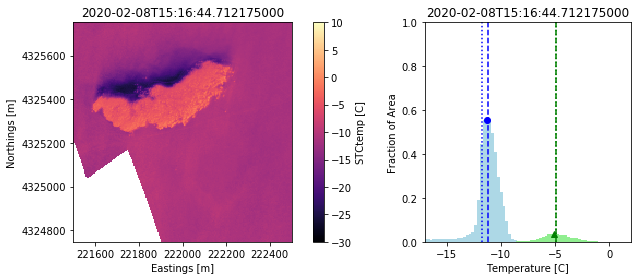

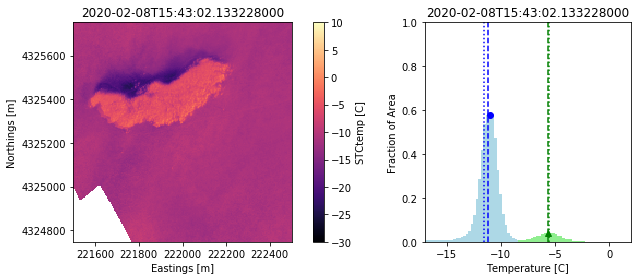

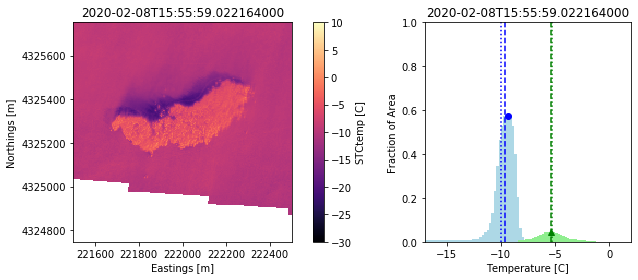

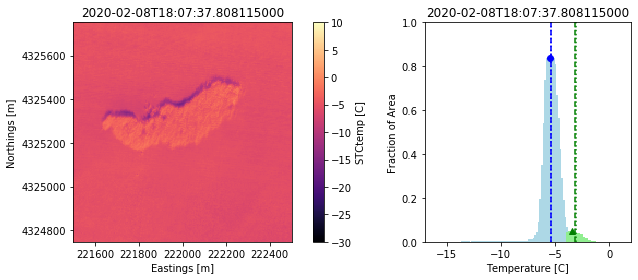

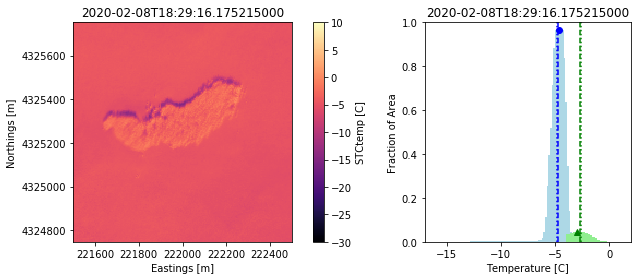

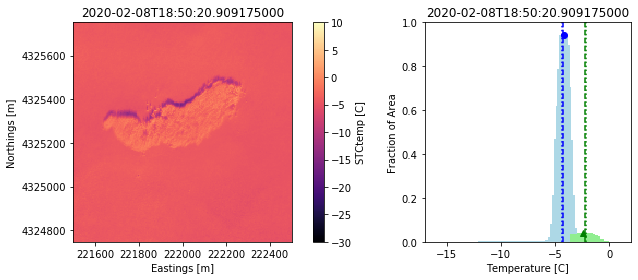

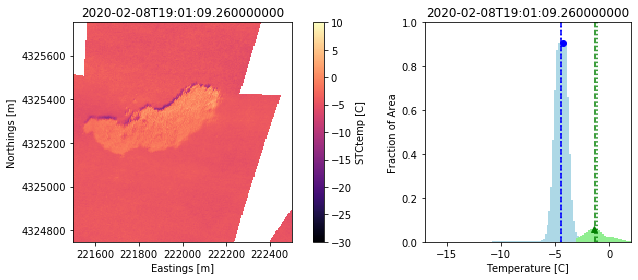

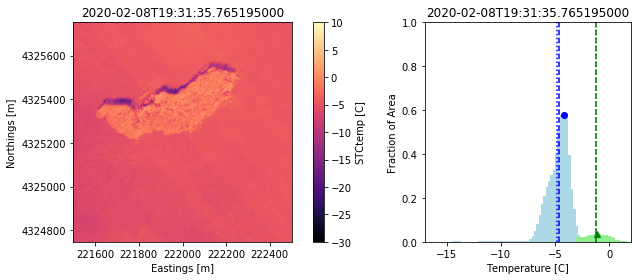

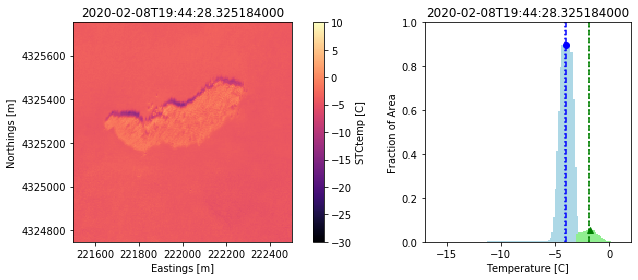

In [59]:
times = []
Tsnow_airborneIR_peak = []
Ttree_airborneIR_peak = []
Tsnow_airborneIR_median = []
Ttree_airborneIR_median = []
Tsnow_airborneIR_mean = []
Ttree_airborneIR_mean = []

for time_step in ds.time:
    nan_pixels = np.sum(np.isnan(ds.STCtemp.sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax), time=time_step).values))
    if nan_pixels < 10000:
        fig, [ax_img, ax_hist] = plt.subplots(nrows=1,ncols=2,figsize=(10,4), tight_layout=True,
                                              gridspec_kw={'width_ratios': [2, 1]})
        ds.STCtemp.sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax), time=time_step).plot(cmap='magma', vmin=-30, vmax=10, ax=ax_img)
        ax_img.set_aspect('equal', 'box')
        ax_img.set_ylabel('Northings [m]')
        ax_img.set_xlabel('Eastings [m]')
        data = ds.STCtemp.sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax), time=time_step).values
        x_peaks, y_peaks, x_hist, y_hist = get_hist_peaks(data)
        x_trough, _, _, _ = get_hist_trough(data)
        x_hist_snow = x_hist[x_hist < x_trough[0]]
        y_hist_snow = y_hist[x_hist < x_trough[0]]
        x_hist_tree = x_hist[x_hist >= x_trough[0]]
        y_hist_tree = y_hist[x_hist >= x_trough[0]]
        ax_hist.bar(x_hist_snow, y_hist_snow, color='lightblue')
        ax_hist.bar(x_hist_tree, y_hist_tree, color='lightgreen')
        ax_hist.axvline(np.median(data[data < x_trough[0]]),color='b',linestyle='--')
        ax_hist.axvline(np.median(data[data >= x_trough[0]]),color='g',linestyle='--')
        ax_hist.axvline(np.mean(data[data < x_trough[0]]),color='b',linestyle=':')
        ax_hist.axvline(np.mean(data[data >= x_trough[0]]),color='g',linestyle=':')
        ax_hist.plot(x_peaks[0], y_peaks[0],'ob')
        ax_hist.plot(x_peaks[1], y_peaks[1],'^g')
        ax_hist.set_xlim(-17, 2)
        ax_hist.set_ylim(0,1)
        ax_hist.set_ylabel('Fraction of Area')
        ax_hist.set_xlabel('Temperature [C]')
        ax_img.set_title(time_step.values)
        ax_hist.set_title(time_step.values)
        # append values to lists
        times.append(time_step.values)
        Tsnow_airborneIR_peak.append(x_peaks[0])
        Ttree_airborneIR_peak.append(x_peaks[1])
        Tsnow_airborneIR_median.append(np.median(data[data < x_trough[0]]))
        Ttree_airborneIR_median.append(np.median(data[data >= x_trough[0]]))
        Tsnow_airborneIR_mean.append(np.mean(data[data < x_trough[0]]))
        Ttree_airborneIR_mean.append(np.mean(data[data >= x_trough[0]]))
        
times = np.array(times)
Tsnow_airborneIR_peak = np.array(Tsnow_airborneIR_peak)
Ttree_airborneIR_peak = np.array(Ttree_airborneIR_peak)
Tsnow_airborneIR_median = np.array(Tsnow_airborneIR_median)
Ttree_airborneIR_median = np.array(Ttree_airborneIR_median)
Tsnow_airborneIR_mean = np.array(Tsnow_airborneIR_mean)
Ttree_airborneIR_mean = np.array(Ttree_airborneIR_mean)

---

---

In [10]:
df = pd.read_csv(r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\SnowEx\SnowEx Met Data\SnowEx2020_met_data\MW-V7_clean.csv')

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
datestrings = [str(df['Year'][i]) + '-' + str(df['DOY'][i]) +'T' + str(df['Hour'][i]) +':' + str(df['Minute'][i]) +':00' for i in range(len(df))]
df['datetime_UTC'] = pd.to_datetime(datestrings, format='%Y-%jT%H:%M:%S') + datetime.timedelta(hours=6)
df.set_index('datetime_UTC', inplace=True)
# select Feb 8th 2020
df = df.where((df.Year==2020) & (df.Month==2) & (df.DOY==39))
df.head()

,Year,DOY,Month,Day,Hour,Minute,Decimal_Year,Flag,AirTC_10ft_Avg_C,RH_10ft_%,...,TCstringC_250cm_Avg,TCstringC_275cm_Avg,TCstringC_300cm_Avg,SM_5cm_Avg,TC_5cm_Avg_C,SM_20cm_Avg_vv,TC_20cm_Avg_C,SM_50cm_Avg_vv,TC_50cm_Avg_C,SnowDepth_m
datetime_UTC,,,,,,,,,,,,,,,,,,,,,
2016-10-10 03:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-10 03:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-10 03:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-10 03:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-10 03:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#df = pd.read_csv('data/example_GOES_4band_tempSep_GrandMesa_Feb82020.csv')
#datestrings = [str(df['year'][i]) + '-' + str(df['doy'][i]) +'T' + str(df['hour'][i]) +':' + str(df['minute'][i]) +':00' for i in range(len(df))]
#df['datetime_UTC'] = pd.to_datetime(datestrings, format='%Y-%jT%H:%M:%S') + datetime.timedelta(hours=6)
#df.set_index('datetime_UTC', inplace=True)
#df.head()

---
---

In [24]:
def compose_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
                 seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    # From: https://stackoverflow.com/questions/34258892/converting-year-and-day-of-year-into-datetime-index-in-pandas
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

In [45]:
# Set column headers:
headers_gm1 = ['table', 'year', 'doy', 'time',
               'rad_avg', 'rad_max', 'rad_min', 'rad_std',
               'sb_avg', 'sb_max', 'sb_min', 'sb_std',
               'temp1_avg', 'temp1_max', 'temp1_min', 'temp1_std',
               'temp2_avg', 'temp2_max', 'temp2_min', 'temp2_std',
               'temp3_avg', 'temp3_max', 'temp3_min', 'temp3_std',
               'temp4_avg', 'temp4_max', 'temp4_min', 'temp4_std',
               'temp5_avg', 'temp5_max', 'temp5_min', 'temp5_std',
               'batt','b',]

# Open ground data from GM1 site:
gm1 = pd.read_csv('data/CR10X_GM1_final_storage_1.dat',
                 header = None, names = headers_gm1)

# Pad zeros to time strings
gm1['time_str'] = [('0' * (4 - len(str(gm1.time[i])))) + str(gm1.time[i]) for i in range(gm1.shape[0])]

for i in range(gm1.shape[0]):
    if gm1.time_str[i] == '2400':
        gm1.time_str[i] = '0000'
        gm1.doy[i] = gm1.doy[i] + 1
        
# Convert year and day of year to pandas datetime index:
gm1['date'] = compose_date(gm1['year'], days=gm1['doy'])
gm1.index = [pd.to_datetime(str(gm1.date[i])[:-9] + 'T' + str(gm1.time_str[i]))  + datetime.timedelta(hours=8) for i in range(gm1.shape[0])]

# Get table 102 entires, battery info
gm1_102 = gm1[gm1.table == 102]

# Remove entries that are part of "Table 102"
gm1 = gm1[gm1.table != 102]

# Remove dates before observation periods (Feb 5th for GM1)
gm1 = gm1[gm1.index >= pd.datetime(2020,2,5,11,0)]

gm1.tail()

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


,table,year,doy,time,rad_avg,rad_max,rad_min,rad_std,sb_avg,sb_max,...,temp4_min,temp4_std,temp5_avg,temp5_max,temp5_min,temp5_std,batt,b,time_str,date
2020-02-12 23:10:00,101,2020,43,1510,-9.3700,-9.0437,-9.7752,0.184,-5.9076,-5.8069,...,-7.3058,0.009,-6.1055,-6.1015,-6.1066,0.002,NaN,NaN,1510,2020-02-12
2020-02-12 23:15:00,101,2020,43,1515,-8.9315,-8.4953,-9.5780,0.336,-6.0095,-5.9826,...,-7.2757,0.013,-6.0973,-6.0916,-6.1065,0.005,NaN,NaN,1515,2020-02-12
2020-02-12 23:20:00,101,2020,43,1520,-10.1200,-9.7869,-10.4040,0.215,-6.4162,-6.0925,...,-7.2557,0.009,-6.1010,-6.0916,-6.1064,0.004,NaN,NaN,1520,2020-02-12
2020-02-12 23:25:00,101,2020,43,1525,-9.5534,-9.2206,-9.9084,0.236,-6.7033,-6.6493,...,-7.2357,0.013,-6.0921,-6.0867,-6.1015,0.005,NaN,NaN,1525,2020-02-12
2020-02-12 23:30:00,101,2020,43,1530,-9.6601,-8.9519,-10.7450,0.551,-6.6635,-6.5886,...,-7.1959,0.005,-6.0883,-6.0868,-6.0918,0.002,NaN,NaN,1530,2020-02-12


(737463.0, 737464.0)

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


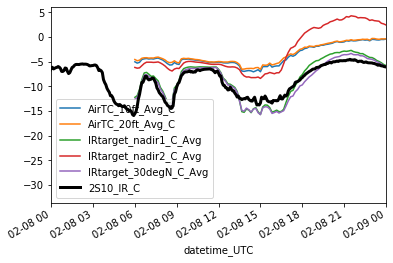

In [46]:

df.AirTC_10ft_Avg_C.plot(label='AirTC_10ft_Avg_C')
df.AirTC_20ft_Avg_C.plot(label='AirTC_20ft_Avg_C')
df.IRtarget_nadir1_C_Avg.plot(label='IRtarget_nadir1_C_Avg')
df.IRtarget_nadir2_C_Avg.plot(label='IRtarget_nadir2_C_Avg')
df.IRtarget_30degN_C_Avg.plot(label='IRtarget_30degN_C_Avg')
gm1.rad_avg.plot(linestyle='-', linewidth=3, c='k', label='2S10_IR_C', zorder=99)
#df.IRtarget_30degS_C_Avg.plot(label='IRtarget_30degS_C_Avg')
#df.TCstringC_75cm_Avg.plot(label='')
#df.TCstringC_100cm_Avg.plot(label='')
plt.legend()
plt.xlim(np.datetime64('2020-02-08T00'),np.datetime64('2020-02-09T00'))

---
---

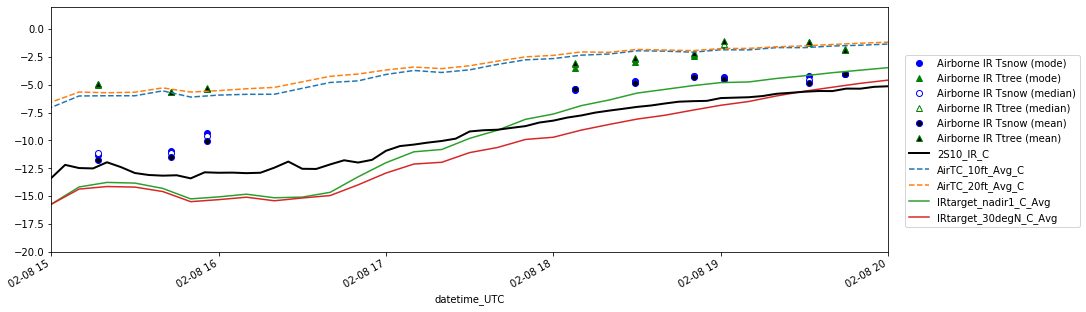

In [60]:
fig, ax =plt.subplots(1,1,figsize=(15,5))



ax.plot(times,Tsnow_airborneIR_peak,'ob', label='Airborne IR Tsnow (mode)')
ax.plot(times,Ttree_airborneIR_peak,'^g', label='Airborne IR Ttree (mode)')
ax.plot(times,Tsnow_airborneIR_median,'ob', markerfacecolor='w', label='Airborne IR Tsnow (median)')
ax.plot(times,Ttree_airborneIR_median,'^g', markerfacecolor='w', label='Airborne IR Ttree (median)')
ax.plot(times,Tsnow_airborneIR_mean,'ob', markerfacecolor='k', label='Airborne IR Tsnow (mean)')
ax.plot(times,Ttree_airborneIR_mean,'^g', markerfacecolor='k', label='Airborne IR Ttree (mean)')


gm1.rad_avg.plot(ax=ax, linestyle='-', linewidth=2, c='k', label='2S10_IR_C', zorder=99)

df.AirTC_10ft_Avg_C.plot(ax=ax, label='AirTC_10ft_Avg_C',linestyle='--')
df.AirTC_20ft_Avg_C.plot(ax=ax, label='AirTC_20ft_Avg_C',linestyle='--')
df.IRtarget_nadir1_C_Avg.plot(ax=ax, label='IRtarget_nadir1_C_Avg')
#df.IRtarget_nadir2_C_Avg.plot(ax=ax, label='IRtarget_nadir2_C_Avg')
df.IRtarget_30degN_C_Avg.plot(ax=ax, label='IRtarget_30degN_C_Avg')
#df.TsnowTrue.plot(ax=ax, c='tab:blue', label='West Met station Tsnow')
#df.TtreeTrue.plot(ax=ax, c='tab:green', label='West Met station Tair')
#df.TsnowEst.plot(marker='.',ax=ax)
#df.TtreeEst.plot(marker='.',ax=ax)

ax.set_xlim(np.datetime64('2020-02-08T15'),np.datetime64('2020-02-08T20'))
ax.set_ylim(-20,2)

plt.legend(loc=(1.02,0.1))

#ax2 = ax.twinx()
#df.Solar.plot(ax=ax2)